Using rfiw2021 venv.

In [1]:
"""
Adapted from Track1/find.py
"""
import sys
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [4]:
print(HERE)
sys.path.insert(0, str(Path(HERE, "..")))  # kinship root
sys.path.insert(0, str(Path(HERE, "..", "rfiw2021")))  # rfiw2021 dir

/warley/dev/research/kinship/notebooks


In [5]:
from dataset import FIWPair  # noqa: E402
from Track1.models import Net  # noqa: E402
from Track1.utils import set_seed  # noqa: E402

In [14]:
def extract_embeddings(val_loader, model, fusion='mean'):
    embeddings = []
    kin_relations = []
    face1_fids = []
    face2_fids = []
    kin_gt = []

    for face1, face2, kin_relation, face1_fid, face2_fid, is_kin in tqdm(val_loader):
        with torch.no_grad():
            embeddings1 = model.encoder(face1.cuda()).cpu().numpy()
            embeddings2 = model.encoder(face2.cuda()).cpu().numpy()
            if fusion == 'mean':
                embeddings.append(np.mean([embeddings1, embeddings2], axis=0))
            elif fusion == 'concat':
                embs = np.concatenate([embeddings1, embeddings2])
                embeddings.append(embs)
            else:
                raise ValueError('Invalid fusion.')
            kin_relations.extend(kin_relation)
            face1_fids.extend(face1_fid.cpu().numpy())
            face2_fids.extend(face2_fid.cpu().numpy())
            kin_gt.extend(is_kin.cpu().numpy())

    # Now, embeddings contain all the embeddings
    embeddings = np.vstack(embeddings)
    kin_relations = np.vstack(kin_relations)
    face1_fids = np.vstack(face1_fids)
    face2_fids = np.vstack(face2_fids)
    kin_gt = np.vstack(kin_gt)

    return embeddings, (kin_relations, face1_fids, face2_fids, kin_gt)

In [21]:
def calculate_embeddings_2d(embeddings, perplexity):
    # This function will calculate the 2D embeddings given the original embeddings and a perplexity value.
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=5000, verbose=1)
    return tsne.fit_transform(embeddings)

def plot_embeddings(embeddings, labels, perplexities, plot_path: str = "", **kwargs):
    # This is the main function that calls the other functions to generate and plot the t-SNE plots.

    # Call filter_embeddings to get the embeddings and labels
    # embeddings, labels = filter_embeddings(embeddings, labels, **kwargs)

    krs, f1fids, f2fids, kin_gt = labels

    # Print number of embeddings, number of unique kin relations, number of kin and non-kin relations
    # Consider kin relations: fs, gmgd, ms, gfgd, bb, md, fd, sibs, gmgs, gfgs, ss
    print(f"Number of embeddings: {len(embeddings)}")
    print(f"Number of unique kin relations: {len(np.unique(krs))}")

    # Define n_subplots based on number of perplexity values
    n_subplots = len(perplexities)
    n_col = n_subplots // 2 if n_subplots > 1 else 1
    n_row = int(np.ceil(n_subplots / n_col))

    # Prepare a figure to hold the subplots
    fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row))
    if n_subplots > 1:
        axes = axes.flatten()  # Flatten the axes array to make it easier to work with
    else:
        axes = [axes]

    # Generate and plot t-SNE for different perplexity values
    for i, perplexity in enumerate(perplexities):
        print(f"Generating t-SNE with perplexity={perplexity}")
        embeddings_2d = calculate_embeddings_2d(embeddings, perplexity)

        ax = axes[i]  # Get the current subplot

        # Plot
        kin_idxs = kin_gt[kin_gt == 1]
        nonkin_idxs = kin_gt[kin_gt == 0]
        ax.scatter(
            embeddings_2d[kin_idxs, 0], embeddings_2d[kin_idxs, 1], color='blue', marker=".", label="kin"
        )
        ax.scatter(
            embeddings_2d[nonkin_idxs, 0],
            embeddings_2d[nonkin_idxs, 1],
            color='red',
            marker="x",
            label="non-kin",
        )
        ax.legend()
        ax.set_title(f"Perplexity: {perplexity}")

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path)
    plt.show()

In [16]:
def setup_data(root_dir, csv_path, batch_size, samples_per_member: int = 1):
    # Loading and sampling the dataset
    val_dataset = FIWPair(
        root_dir=root_dir, csv_path=csv_path, families=[250, 283, 409, 735, 873], samples_per_member=samples_per_member
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)
    return val_loader

In [9]:
def setup_model(model_path):
    # Loading model
    model = Net().cuda()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    set_seed(100)

    return model

In [10]:
root_dir = Path(HERE, "../rfiw2021/Track1/")
csv_path = Path(HERE, "../rfiw2021/Track1/sample0/val.txt")
batch_size = 40
model_path = Path(HERE, "../rfiw2021/Track1/model_track1.pth")
plot_path = ""

In [11]:
model = setup_model(model_path)

In [12]:
val_loader = setup_data(root_dir, csv_path, batch_size)

Total samples: 5846


In [17]:
# Extracting embeddings
embeddings, labels = extract_embeddings(val_loader, model, fusion='concat')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:35<00:00,  4.18it/s]


In [ ]:
kin_gt = labels[-1]
print(f"Kin == 1: {len(kin_gt[kin_gt == 1])")
print(f"Kin == 0: {len(kin_gt[kin_gt == 0])")

Number of embeddings: 11692
Number of unique kin relations: 11
Generating t-SNE with perplexity=10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 11692 samples in 0.002s...
[t-SNE] Computed neighbors for 11692 samples in 0.560s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11692
[t-SNE] Computed conditional probabilities for sample 2000 / 11692
[t-SNE] Computed conditional probabilities for sample 3000 / 11692
[t-SNE] Computed conditional probabilities for sample 4000 / 11692
[t-SNE] Computed conditional probabilities for sample 5000 / 11692
[t-SNE] Computed conditional probabilities for sample 6000 / 11692
[t-SNE] Computed conditional probabilities for sample 7000 / 11692
[t-SNE] Computed conditional probabilities for sample 8000 / 11692
[t-SNE] Computed conditional probabilities for sample 9000 / 11692
[t-SNE] Computed conditional probabilities for sample 10000 / 11692
[t-SNE] Computed conditional probabilities for sample 11000 / 11692
[t-SNE] Computed co

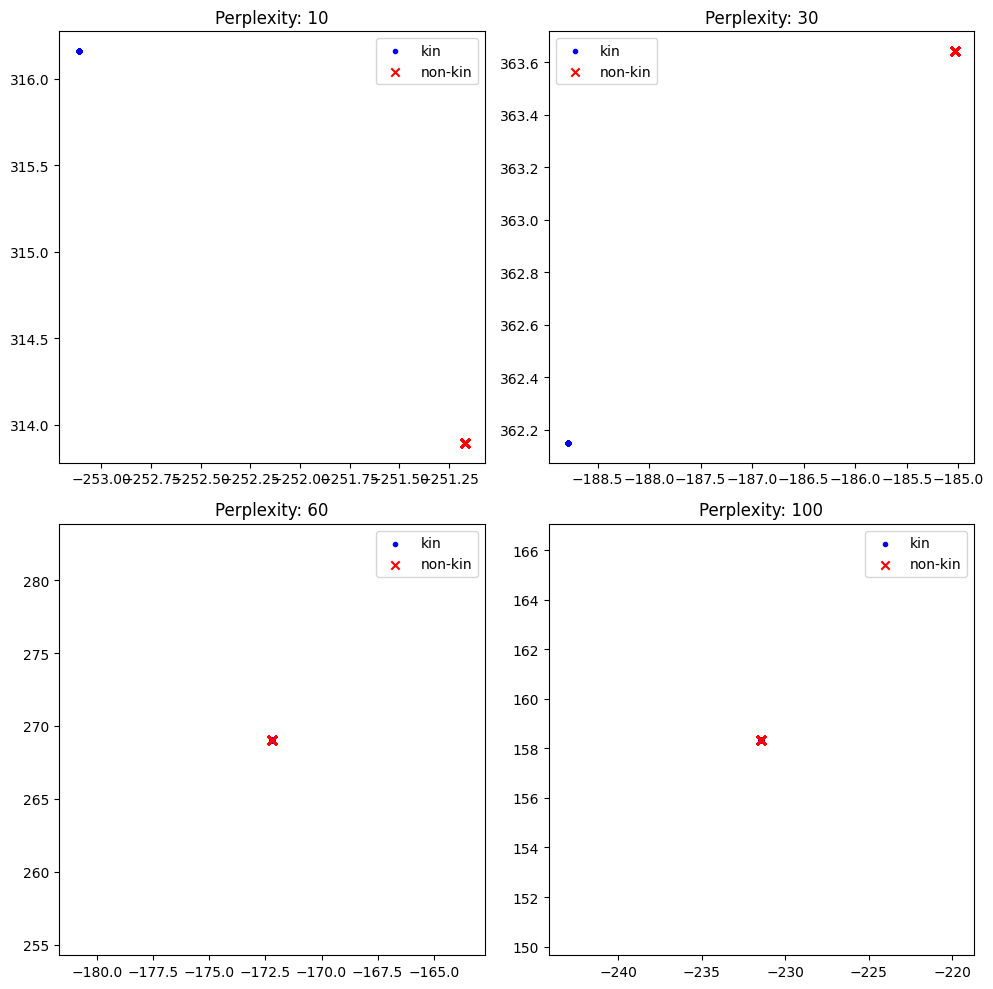

In [22]:
# Plotting
perplexities = [10, 30, 60, 100]
plot_embeddings(embeddings, labels, perplexities)